In [18]:
from pathlib import Path
from tifffile import imread
from typing import Union
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from stardist.matching import matching_dataset
sys.path.append("../")

In [19]:
def dice_coeff(
    y_true: np.ndarray,
    y_pred: np.ndarray,
) -> np.float64:
    """Compute Dice-Sorensen coefficient between two numpy arrays
    Args:
        y_true: Ground truth label
        y_pred: Prediction label
    Returns: dice coefficient
    """
    sum_tensor = np.sum
    smooth = 1.0
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = sum_tensor(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (
        sum_tensor(y_true_f) + sum_tensor(y_pred_f) + smooth
    )
    return score


def intersection_over_union(
    y_true: np.ndarray, y_pred: np.ndarray
) -> np.float64:
    """Compute Intersection over Union between two numpy arrays
    Args:
        y_true: Ground truth label
        y_pred: Prediction label
    Returns: IoU
    """
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return intersection / union


def precision(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """Compute precision between two numpy arrays
    Args:
        y_true: Ground truth label
        y_pred: Prediction label
    Returns: precision
    """
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return intersection / np.sum(y_pred_f)


def recall(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """Compute recall between two numpy arrays
    Args:
        y_true: Ground truth label
        y_pred: Prediction label
    Returns: recall
    """
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return intersection / np.sum(y_true_f)

In [20]:
def plot_model_performance_semantic(
    image, gt, name, threshold_range=None, print_max=True
):
    """Plot the Dice, IoU, precision and recall for a given model and threshold range, across the specified threshold range between 0 and 1"""
    if threshold_range is None:
        threshold_range = np.arange(0, 1, 0.025)

    dice_scores = []
    iou_scores = []
    precision_scores = []
    recall_scores = []
    for threshold in threshold_range:
        pred = np.where(image > threshold, 1, 0)
        dice_scores.append(dice_coeff(gt, pred))
        iou_scores.append(intersection_over_union(gt, pred))
        precision_scores.append(precision(gt, pred))
        recall_scores.append(recall(gt, pred))
    plt.figure(figsize=(7, 7))
    plt.plot(threshold_range, dice_scores, label="Dice")
    plt.plot(threshold_range, iou_scores, label="IoU")
    plt.plot(threshold_range, precision_scores, label="Precision")
    plt.plot(threshold_range, recall_scores, label="Recall")
    # draw optimal threshold at max Dice score
    optimal_threshold = threshold_range[np.argmax(dice_scores)]
    plt.axvline(optimal_threshold, color="black", linestyle="--")
    # label line as optimal threshold at the bottom
    plt.text(
        optimal_threshold - 0.25,
        0,
        f"Max Dice @ {optimal_threshold:.2f}",
        verticalalignment="bottom",
    )
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Model performance for {name}")
    plt.legend()
    plt.show()

    if print_max:
        print(
            f"Max Dice of {np.max(dice_scores):.2f} @ {threshold_range[np.argmax(dice_scores)]:.2f}"
        )
        print(
            f"Max IoU of {np.max(iou_scores):.2f} @ {threshold_range[np.argmax(iou_scores)]:.2f}"
        )

    return dice_scores, iou_scores, precision_scores, recall_scores

In [21]:
image_folder = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SPLITS/Analysis"
c5 = imread(image_folder / "c5.tif")
c3 = imread(image_folder / "c3.tif")
visual = imread(image_folder / "visual.tif")

visual_slice = 50
# visual_slice = -1

gt_dict = {
    "visual": visual[:visual_slice,:,:],
    "c3": c3,
    "c5": c5,
}

In [22]:
visual_preds = {
    "cellpose": {
        "8020": image_folder / "c1_5/cp/iso_visual_c1-5_visual_8020.tif",
        # "8020": image_folder / "c1_5/cp_radius5/iso_visual_c1-5_visual_8020.tif",
        "6040": image_folder / "c1_5/cp/iso_visual_c1-5_visual_6040.tif",
        # "6040": image_folder / "c1_5/cp_radius5/iso_visual_c1-5_visual_6040.tif"
        "2080": image_folder / "c1_5/cp/iso_visual_c1-5_visual_2080.tif"
    },
    "stardist": {
        "8020": image_folder / "c1_5/sd/stardist_8020_labels.tif",
        "6040": image_folder / "c1_5/sd/stardist_6040_labels.tif",
        "2080": image_folder / "c1_5/sd/stardist_2080_labels.tif"
    },
    "segres": {
        "8020": image_folder / "c1_5/segres/c1_5_8020_SegRes.tif",
        "6040": image_folder / "c1_5/segres/c1_5_6040_SegRes.tif",
        "2080": image_folder / "c1_5/segres/c1_5_2080_SegRes.tif"
        
    },
    "swin": {
        "8020": image_folder / "c1_5/swin/c1-5_8020_Swin.tif",
        "6040": image_folder / "c1_5/swin/c1-5_6040_Swin.tif",
        "2080": image_folder / "c1_5/swin/c1-5_2080_Swin.tif",
    },
}
c3_preds = {
    "cellpose": {
        "8020": image_folder / "c1245_v/cp/c3image_c1245_v_8020.tif",
        "6040": image_folder / "c1245_v/cp/c3image_c1245_v_6040.tif",
        "2080": image_folder / "c1245_v/cp/c3image_c1245_v_2080.tif"
    },
    "stardist": {
        "8020": image_folder / "c1245_v/sd/stardist_8020_labels.tif",
        "6040": image_folder / "c1245_v/sd/stardist_6040_labels.tif",
        "2080": image_folder / "c1245_v/sd/stardist_2080_labels.tif"
    },
    "segres": {
        "8020": image_folder / "c1245_v/segres/c1245-v_8020_SegRes.tif",
        "6040": image_folder / "c1245_v/segres/c1245-v_6040_SegRes.tif",
        "2080": image_folder / "c1245_v/segres/c1245-v_2080_SegRes.tif"
    },
    "swin": {
        "8020": image_folder / "c1245_v/swin/c1245-v_8020_Swin.tif",
        "6040": image_folder / "c1245_v/swin/c1245-v_6040_Swin.tif",
        "2080": image_folder / "c1245_v/swin/c1245-v_2080_Swin.tif"
    },
}
c5_preds = {
    "cellpose": {
        "8020": image_folder / "c1-4_v/cp/c5image_c1-4_v_8020.tif",
        "6040": image_folder / "c1-4_v/cp/c5image_c1-4_v_6040.tif",
        "2080": image_folder / "c1-4_v/cp/c5image_c1-4_v_2080.tif"
    },
    "stardist": {
        "8020": image_folder / "c1-4_v/sd/stardist_8020_labels.tif",
        "6040": image_folder / "c1-4_v/sd/stardist_6040_labels.tif",
        "2080": image_folder / "c1-4_v/sd/stardist_2080_labels.tif"
    },
    "segres": {
        "8020": image_folder / "c1-4_v/segres/c1-4-v_8020_SegRes.tif",
        "6040": image_folder / "c1-4_v/segres/c1-4-v_6040_SegRes.tif",
        "2080": image_folder / "c1-4_v/segres/c1-4-v_2080_SegRes.tif"
    },
    "swin": {
        "8020": image_folder / "c1-4_v/swin/c1-4-v_8020_Swin.tif",
        "6040": image_folder / "c1-4_v/swin/c1-4-v_6040_Swin.tif",
        "2080": image_folder / "c1-4_v/swin/c1-4-v_2080_Swin.tif"
    },
}

In [23]:
cellpose_preds = {
    "2080": {
        "visual": imread(visual_preds["cellpose"]["2080"])[:visual_slice,:,:],
        "c3": imread(c3_preds["cellpose"]["2080"]),
        "c5": imread(c5_preds["cellpose"]["2080"]),
    },
    "6040": {
        "visual": imread(visual_preds["cellpose"]["6040"])[:visual_slice,:,:],
        "c3": imread(c3_preds["cellpose"]["6040"]),
        "c5": imread(c5_preds["cellpose"]["6040"]),
    },
    "8020": {
        "visual": imread(visual_preds["cellpose"]["8020"])[:visual_slice,:,:],
        "c3": imread(c3_preds["cellpose"]["8020"]),
        "c5": imread(c5_preds["cellpose"]["8020"]),
    },
}
stardist_preds = {
    "2080": {
        "visual": imread(visual_preds["stardist"]["2080"])[:visual_slice,:,:],
        "c3": imread(c3_preds["stardist"]["2080"]),
        "c5": imread(c5_preds["stardist"]["2080"]),
    },
    "6040": {
        "visual": imread(visual_preds["stardist"]["6040"])[:visual_slice,:,:],
        "c3": imread(c3_preds["stardist"]["6040"]),
        "c5": imread(c5_preds["stardist"]["6040"]),
    },
    "8020": {
        "visual": imread(visual_preds["stardist"]["8020"])[:visual_slice,:,:],
        "c3": imread(c3_preds["stardist"]["8020"]),
        "c5": imread(c5_preds["stardist"]["8020"]),
    },
}
segres_preds = {
    "2080": {
        "visual": imread(visual_preds["segres"]["2080"])[:visual_slice,:,:],
        "c3": imread(c3_preds["segres"]["2080"]),
        "c5": imread(c5_preds["segres"]["2080"]),
    },
    "6040": {
        "visual": imread(visual_preds["segres"]["6040"])[:visual_slice,:,:],
        "c3": imread(c3_preds["segres"]["6040"]),
        "c5": imread(c5_preds["segres"]["6040"]),
    },
    "8020": {
        "visual": imread(visual_preds["segres"]["8020"])[:visual_slice,:,:],
        "c3": imread(c3_preds["segres"]["8020"]),
        "c5": imread(c5_preds["segres"]["8020"]),
    },
}
swin_preds = {
    "2080": {
        "visual": imread(visual_preds["swin"]["2080"])[:visual_slice,:,:],
        "c3": imread(c3_preds["swin"]["2080"]),
        "c5": imread(c5_preds["swin"]["2080"]),
    },
    "6040": {
        "visual": imread(visual_preds["swin"]["6040"])[:visual_slice,:,:],
        "c3": imread(c3_preds["swin"]["6040"]),
        "c5": imread(c5_preds["swin"]["6040"]),
    },
    "8020": {
        "visual": imread(visual_preds["swin"]["8020"])[:visual_slice,:,:],
        "c3": imread(c3_preds["swin"]["8020"]),
        "c5": imread(c5_preds["swin"]["8020"]),
    },
}
wnet_preds = {
    "2080": {
        "visual": imread(image_folder / "WNet/visual_pred.tif")[:visual_slice,:,:],
        "c3": imread(image_folder / "WNet/c3_pred.tif"),
        "c5": imread(image_folder / "WNet/c5_pred.tif"),
    },
    "6040": {
        "visual": imread(image_folder / "WNet/visual_pred.tif")[:visual_slice,:,:],
        "c3": imread(image_folder / "WNet/c3_pred.tif"),
        "c5": imread(image_folder / "WNet/c5_pred.tif"),
    },
    "8020": {
        "visual": imread(image_folder / "WNet/visual_pred.tif")[:visual_slice,:,:],
        "c3": imread(image_folder / "WNet/c3_pred.tif"),
        "c5": imread(image_folder / "WNet/c5_pred.tif"),
    },
}

In [24]:
def model_dices_across_splits(model_dict):
    model_dices = {
        "2080": [],
        "6040": [],
        "8020": [],
    }
    for split in model_dict:
        for image in model_dict[split]:
            print(f"Split: {split}, Image: {image}")
            print(f"Image shape: {model_dict[split][image].shape}")
            print(f"GT shape: {gt_dict[image].shape}")
            gt = gt_dict[image]
            pred = model_dict[split][image]
            gt = np.where(gt > 0, 1, 0)
            pred = np.where(pred > 0, 1, 0)
            dice = dice_coeff(gt, pred)
            print(f"Dice: {dice}")
            model_dices[split].append(dice)
    return model_dices

In [25]:
cellpose_dices = model_dices_across_splits(cellpose_preds)

Split: 2080, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.3897810218978102
Split: 2080, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.41333207922388543
Split: 2080, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.4346342300432785
Split: 6040, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.32975496609967886
Split: 6040, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.46105638941004795
Split: 6040, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.28778826871657753
Split: 8020, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.5462526711464689
Split: 8020, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.3586485504207554
Split: 8020, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.4212584018642991


In [26]:
stardist_dices = model_dices_across_splits(stardist_preds)

Split: 2080, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.7000729374140882
Split: 2080, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 1.7072712683318253e-05
Split: 2080, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 2.441108263151471e-05
Split: 6040, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.6547947996383686
Split: 6040, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.5219389414443077
Split: 6040, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.725773126793911
Split: 8020, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.6696363730677456
Split: 8020, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.5228543567663311
Split: 8020, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.6306411323896752


In [27]:
segres_dices = model_dices_across_splits(segres_preds)

Split: 2080, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.7818412571180469
Split: 2080, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.690604379266495
Split: 2080, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.8011690505093154
Split: 6040, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.7482627642659443
Split: 6040, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.8407463430415053
Split: 6040, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.6176906743958748
Split: 8020, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.7742763592762825
Split: 8020, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.7732059262568924
Split: 8020, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.6349198430120402


In [28]:
swin_dices = model_dices_across_splits(swin_preds)

Split: 2080, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.825505078870934
Split: 2080, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.8358747923406488
Split: 2080, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)


Dice: 0.8351299684040039
Split: 6040, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.834037286603933
Split: 6040, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.848574773573554
Split: 6040, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.8382282793867121
Split: 8020, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.843205100791167
Split: 8020, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.8399061788580495
Split: 8020, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.8205994504570179


In [29]:
wnet_dices = model_dices_across_splits(wnet_preds)

Split: 2080, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.8179572126452918
Split: 2080, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.8113536341409202
Split: 2080, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)


Dice: 0.8087545264446371
Split: 6040, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.8179572126452918
Split: 6040, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.8113536341409202
Split: 6040, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.8087545264446371
Split: 8020, Image: visual
Image shape: (50, 127, 214)
GT shape: (50, 127, 214)
Dice: 0.8179572126452918
Split: 8020, Image: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 0.8113536341409202
Split: 8020, Image: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.8087545264446371


In [30]:
model_names = ["Cellpose", "Stardist", "SegResNet", "SwinUNetR", "WNet (all data)"]
models = [cellpose_dices, stardist_dices, segres_dices, swin_dices]
wnet_means = [np.mean(wnet_dices["8020"]), np.mean(wnet_dices["6040"]), np.mean(wnet_dices["2080"])]

plt.rcParams["figure.figsize"] = (8, 8)

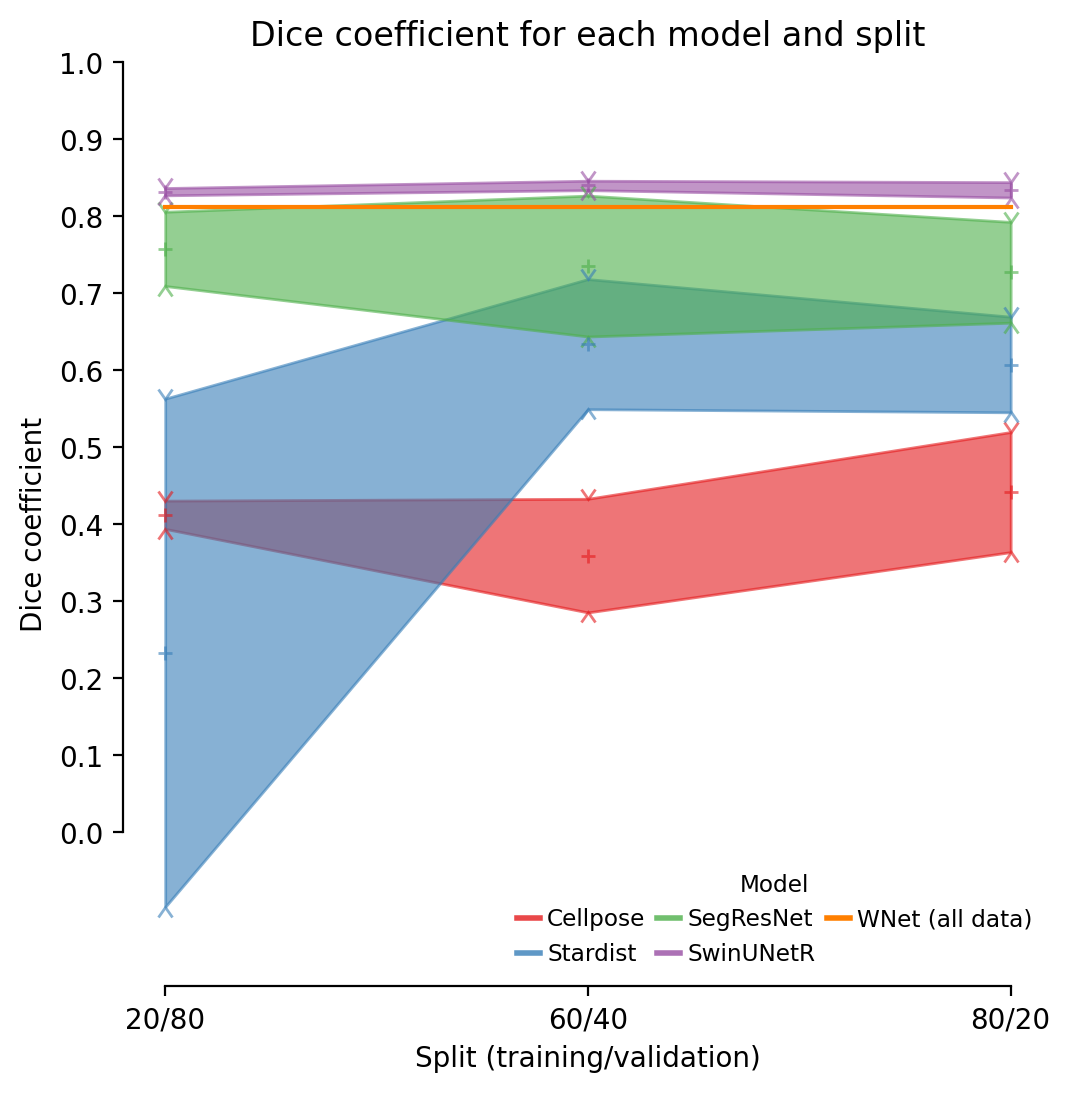

In [31]:
def set_marker_errorbar(c):
    for i, mark in enumerate([6, 7]):
        c.lines[1][i].set_marker(mark)
        c.lines[1][i].set_markersize(5)
        c.lines[1][i].set_markerfacecolor("None")

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors) # change deafault cycler to use Set1
plt.figure(figsize=(6,6), dpi=200)
ax = plt.gca()

for i, model in enumerate(models):
    mean_dices = []
    std_dices = []
    for split in model:
        dices = sorted(model[split])
        mean_dices.append(np.mean(dices))
        std_dices.append(np.std(dices))
    l=ax.plot(mean_dices, label=model_names[i], linewidth=2, alpha=0.8)
    ax.fill_between(
        range(len(mean_dices)),
        (np.array(mean_dices) - np.array(std_dices)),
        np.array(mean_dices) + np.array(std_dices),
        alpha=0.6,
        color=l[0].get_color(),
        )
    [lin.set_linewidth(0) for lin in l]
    c = ax.errorbar(
        range(len(mean_dices)), 
        mean_dices, 
        yerr=std_dices,
        fmt='+', 
        alpha=0.6,
        markersize=5,
        linewidth=0,
        capsize=20,
        color=l[0].get_color(),
        dash_capstyle="round",
        )
    set_marker_errorbar(c)
l = ax.plot(
    wnet_means, 
    label=model_names[-1], 
    # linestyle="--"
        ) 
ax.set_ylim([-0.2,1])
plt.xticks([0,1,2], ["20/80","60/40","80/20"])
plt.yticks(np.arange(0,1.1,0.1))
leg = ax.legend(
    loc="best",
    title="Model",
    frameon=False,
    ncol=3,
    # nrow=4,
    handlelength=1,
    markerscale=0.0,
    labelspacing=0.5,
    columnspacing=0.5,
    handletextpad=0.3,
    fontsize="small",
    title_fontsize="small",
)   
for legobj in leg.legend_handles:
    legobj.set_linewidth(2.0)
plt.xlabel("Split (training/validation)")
plt.ylabel("Dice coefficient")
plt.title("Dice coefficient for each model and split")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
sns.despine(trim=True)   
plt.show()

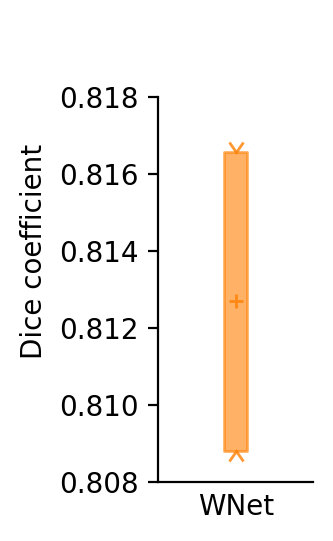

In [32]:
plt.figure(figsize=(1,3), dpi=200)
ax = plt.gca()

ax.plot(
    [0],
    wnet_means[0], 
    label=model_names[-1], 
    color=l[-1].get_color(),
        ) 

c = ax.errorbar(
        0, 
        wnet_means[0], 
        yerr=[np.std(wnet_dices["2080"])],
        fmt='+', 
        alpha=0.8,
        markersize=5,
        linewidth=0,
        capsize=20,
        color=l[0].get_color(),
        dash_capstyle="round",
        )
ax.fill_between(
        [-0.03,0.03],
        np.max(wnet_means[0]) - np.std(wnet_dices["2080"]),
        np.min(wnet_means[0]) + np.std(wnet_dices["2080"]),
        alpha=0.6,
        color=l[0].get_color(),
        )
set_marker_errorbar(c)
ax.set_ylim([0.808,0.82])
ax.set_xlim([-0.2,0.2])
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 

plt.xlabel("WNet")
plt.ylabel("Dice coefficient")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
sns.despine(trim=True)   
plt.show()

In [34]:
# creata a dataframe with each model dice, adding the split as a categorical variable
dices_df = pd.DataFrame(columns=["Model", "Dice", "Split"])
dices_df["Model"] = ["Cellpose"] * 9 + ["Stardist"] * 9 + ["SegResNet"] * 9 + ["SwinUNetR"] * 9 + ["WNet"] * 9
dices_df["Dice"] = cellpose_dices["2080"] + cellpose_dices["6040"] + cellpose_dices["8020"] + stardist_dices["2080"] + stardist_dices["6040"] + stardist_dices["8020"] + segres_dices["2080"] + segres_dices["6040"] + segres_dices["8020"] + swin_dices["2080"] + swin_dices["6040"] + swin_dices["8020"] + wnet_dices["2080"] + wnet_dices["6040"] + wnet_dices["8020"]
dices_df["Split"] = ["20/80"] * 3 + ["60/40"] * 3 + ["80/20"] * 3 + ["20/80"] * 3 + ["60/40"] * 3 + ["80/20"] * 3 + ["20/80"] * 3 + ["60/40"] * 3 + ["80/20"] * 3 + ["20/80"] * 3 + ["60/40"] * 3 + ["80/20"] * 3 + ["20/80"] *3 + ["60/40"]*3 + ["80/20"]*3

<Axes: xlabel='Model', ylabel='Dice'>

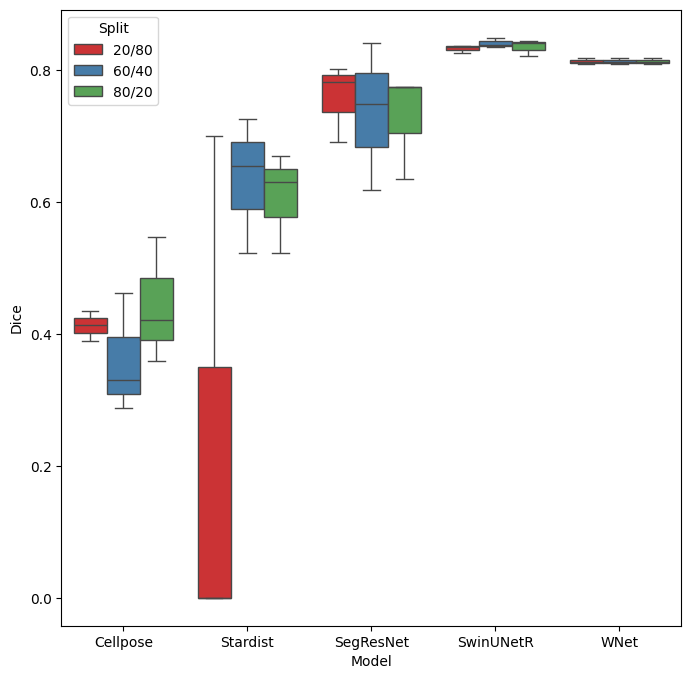

In [37]:
sns.boxplot(data=dices_df, x="Model", y="Dice", hue="Split")

In [ ]:
# plot dices for each model with split on x axis
# plot as confidence interval with min, max, middle values

# for i, model in enumerate(models):
#     max_dices = []
#     min_dices = []
#     middle_dices = []
#     for split in model:
#         dices = sorted(model[split])
#         max_dices.append(dices[-1])
#         min_dices.append(dices[0])
#         middle_dices.append(dices[1])
#     plt.plot(middle_dices, label=model_names[i])
#     # fill between according to std
#     plt.fill_between(range(len(middle_dices)), min_dices, max_dices, alpha=0.2)

# # plt.hlines(wnet_means, 0, 1, label="wnet", linestyles="dashed", colors="purple")       
# plt.legend()
# # set xticks to be split names
# plt.xticks([0,1,2], ["20/80","60/40","80/20"])
# plt.xlabel("Split")
# plt.ylabel("Dice coefficient")
# plt.title("Dice coefficient for each model and split")
# # plt.xlim(-0.2, 1.2)
# plt.show()

In [ ]:
# # plot dices for each model with split on x axis
# # plot as confidence interval with min, max, middle values
# for i, model in enumerate(models):
#     max_dices = []
#     min_dices = []
#     middle_dices = []
#     for split in model:
#         dices = sorted(model[split])
#         max_dices.append(dices[-1])
#         min_dices.append(dices[0])
#         middle_dices.append(dices[1])
#     plt.plot(middle_dices, label=model_names[i])
#     # show error bars with min and max with same color as line and 0.2 alpha
#     plt.errorbar(range(len(middle_dices)), middle_dices, yerr=[np.array(middle_dices) - np.array(min_dices), np.array(max_dices) - np.array(middle_dices)], fmt='o', color=plt.gca().lines[-1].get_color(), alpha=0.7)
#     plt.fill_between(range(len(middle_dices)), min_dices, max_dices, alpha=0.2)
# # plt.plot(wnet_means, label="wnet")
# plt.hlines(wnet_means, 0, 2, label="wnet", linestyles="dashed", colors="purple")   
# plt.legend()
# # set xticks to be split names
# plt.xticks([0,1,2], ["20/80","60/40","80/20"])
# plt.xlabel("Split")
# plt.ylabel("Dice coefficient")
# plt.title("Dice coefficient for each model and split")
# # plt.xlim(-0.2, 1.2)
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.show()